# Running models individually for each house

In [1]:
import warnings
warnings.filterwarnings('ignore',category=FutureWarning)
warnings.filterwarnings('ignore',category=DeprecationWarning)
import sys
sys.path.append("..")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
import time
import xgboost as xgb
from cuml.ensemble import RandomForestRegressor as cuRF
from scripts.function_utils import last_energy_points, build_predict_show, total_averaged_metrics_individual, show_graphic_per_timestep, build_predict_show_rf, show_all_metrics_per_house

In [2]:
df = pd.read_csv("../../data/loureiro_45houses.csv")
number_of_houses = df.shape[1] - 1
df.Time = pd.to_datetime(df.Time)
df

,Time,Energy_1,Energy_2,Energy_9,Energy_11,Energy_15,Energy_16,Energy_17,Energy_29,Energy_30,...,Energy_139,Energy_142,Energy_146,Energy_148,Energy_151,Energy_159,Energy_160,Energy_161,Energy_164,Energy_172
0,2022-05-05 12:00:00,0.068,0.018,0.024,0.114,0.164,0.072,0.055,0.011,0.006,...,0.083,0.084,0.068,0.060,0.042,0.055,0.069,0.010,0.004,0.008
1,2022-05-05 12:15:00,0.070,0.018,0.024,0.190,0.135,0.058,0.060,0.002,0.006,...,0.053,0.004,0.048,0.078,0.053,0.055,0.063,0.010,0.003,0.056
2,2022-05-05 12:30:00,0.122,0.018,0.024,0.180,0.121,0.011,0.096,0.010,0.006,...,0.035,0.004,0.062,0.061,0.057,0.055,0.049,0.010,0.004,0.033
3,2022-05-05 12:45:00,0.132,0.018,0.024,0.167,0.138,0.010,0.064,0.004,0.006,...,0.082,0.004,0.056,0.125,0.034,0.055,0.097,0.010,0.004,0.062
4,2022-05-05 13:00:00,0.125,0.018,0.024,0.133,0.104,0.011,0.072,0.002,0.006,...,0.076,0.004,0.034,0.070,0.038,0.055,0.075,0.010,0.004,0.024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38011,2023-06-05 10:45:00,0.094,0.032,0.074,0.203,0.108,0.002,0.124,0.012,0.013,...,0.063,0.004,0.063,0.014,0.042,0.168,0.397,0.019,0.003,0.028
38012,2023-06-05 11:00:00,0.094,0.032,0.074,0.203,0.108,0.002,0.124,0.012,0.013,...,0.063,0.004,0.063,0.014,0.042,0.168,0.397,0.019,0.003,0.028
38013,2023-06-05 11:15:00,0.094,0.032,0.074,0.203,0.108,0.002,0.124,0.012,0.013,...,0.063,0.004,0.063,0.014,0.042,0.168,0.397,0.019,0.003,0.028
38014,2023-06-05 11:30:00,0.094,0.032,0.074,0.203,0.108,0.002,0.124,0.012,0.013,...,0.063,0.004,0.063,0.014,0.042,0.168,0.397,0.019,0.003,0.028


## Preprocessing

In [3]:
X,y = last_energy_points(df.Energy_1, 97)
print(X.shape, y.shape)
X

(37919, 97) (37919, 1)


,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,...,lag_88,lag_89,lag_90,lag_91,lag_92,lag_93,lag_94,lag_95,lag_96,lag_97
0,0.057,0.086,0.041,0.061,0.637,0.329,0.063,0.047,0.076,0.057,...,0.156,0.091,0.111,0.112,0.089,0.125,0.132,0.122,0.070,0.068
1,0.065,0.057,0.086,0.041,0.061,0.637,0.329,0.063,0.047,0.076,...,0.377,0.156,0.091,0.111,0.112,0.089,0.125,0.132,0.122,0.070
2,0.030,0.065,0.057,0.086,0.041,0.061,0.637,0.329,0.063,0.047,...,0.089,0.377,0.156,0.091,0.111,0.112,0.089,0.125,0.132,0.122
3,0.329,0.030,0.065,0.057,0.086,0.041,0.061,0.637,0.329,0.063,...,0.096,0.089,0.377,0.156,0.091,0.111,0.112,0.089,0.125,0.132
4,0.329,0.329,0.030,0.065,0.057,0.086,0.041,0.061,0.637,0.329,...,0.093,0.096,0.089,0.377,0.156,0.091,0.111,0.112,0.089,0.125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37914,0.094,0.094,0.094,0.094,0.094,0.094,0.094,0.094,0.094,0.094,...,0.065,0.055,0.507,0.155,0.053,0.264,0.339,0.042,0.032,0.046
37915,0.094,0.094,0.094,0.094,0.094,0.094,0.094,0.094,0.094,0.094,...,0.074,0.065,0.055,0.507,0.155,0.053,0.264,0.339,0.042,0.032
37916,0.094,0.094,0.094,0.094,0.094,0.094,0.094,0.094,0.094,0.094,...,0.055,0.074,0.065,0.055,0.507,0.155,0.053,0.264,0.339,0.042
37917,0.094,0.094,0.094,0.094,0.094,0.094,0.094,0.094,0.094,0.094,...,0.061,0.055,0.074,0.065,0.055,0.507,0.155,0.053,0.264,0.339


## Test model

In [4]:
start_timestep = 97
number_timesteps = 97

## Linear Regression

In [5]:
df.columns[1:]

Index(['Energy_1', 'Energy_2', 'Energy_9', 'Energy_11', 'Energy_15',
       'Energy_16', 'Energy_17', 'Energy_29', 'Energy_30', 'Energy_35',
       'Energy_48', 'Energy_58', 'Energy_60', 'Energy_65', 'Energy_78',
       'Energy_86', 'Energy_90', 'Energy_91', 'Energy_94', 'Energy_95',
       'Energy_96', 'Energy_106', 'Energy_108', 'Energy_110', 'Energy_117',
       'Energy_118', 'Energy_123', 'Energy_125', 'Energy_126', 'Energy_127',
       'Energy_129', 'Energy_132', 'Energy_135', 'Energy_136', 'Energy_138',
       'Energy_139', 'Energy_142', 'Energy_146', 'Energy_148', 'Energy_151',
       'Energy_159', 'Energy_160', 'Energy_161', 'Energy_164', 'Energy_172'],
      dtype='object')

In [6]:
model_lr, preds_lr, metrics_list_lr = [],[],[]
start_t = time.time()
for house in df.columns[1:]:
    print("\n House {}".format(house))
    mo_lr, p_lr, ml_lr = build_predict_show(pd.DataFrame(df[house]), number_timesteps, LinearRegression(), selected_features=[1,2,3,4,96,192,288,384,480,576,672], start_timestep=start_timestep)
    model_lr.append(mo_lr)
    preds_lr.append(p_lr)
    metrics_list_lr.append(ml_lr)
print("\nLinear Regression Elapsed time: %.3f seconds" % (time.time() - start_t))


 House Energy_1

Number of features  97
RMSE: 0.0650
WAPE: 33.58
R2: 0.3703
RMSE: 0.0632
WAPE: 32.45
R2: 0.4002
RMSE: 0.0612
WAPE: 36.81
R2: 0.4558
RMSE: 0.0551
WAPE: 36.91
R2: 0.4870
RMSE: 0.0632
WAPE: 36.39
R2: 0.4290
RMSE: 0.0856
WAPE: 36.16
R2: 0.6415
RMSE: 0.0984
WAPE: 36.95
R2: 0.7351
RMSE: 0.0706
WAPE: 37.72
R2: 0.5740
RMSE: 0.0686
WAPE: 38.26
R2: 0.3527
RMSE: 0.0611
WAPE: 36.45
R2: 0.4068

Elapsed time: 0.157 seconds

Full Elapsed time: 0.157 seconds

 House Energy_2

Number of features  97
RMSE: 0.0465
WAPE: 45.42
R2: 0.2764
RMSE: 0.0477
WAPE: 45.65
R2: 0.2972
RMSE: 0.0475
WAPE: 48.26
R2: 0.2132
RMSE: 0.0556
WAPE: 53.85
R2: 0.2629
RMSE: 0.0578
WAPE: 54.67
R2: 0.3500
RMSE: 0.0630
WAPE: 55.38
R2: 0.3142
RMSE: 0.0702
WAPE: 57.95
R2: 0.4588
RMSE: 0.0594
WAPE: 56.62
R2: 0.3035
RMSE: 0.0525
WAPE: 55.27
R2: 0.2713
RMSE: 0.0504
WAPE: 50.60
R2: 0.3257

Elapsed time: 0.116 seconds

Full Elapsed time: 0.116 seconds

 House Energy_9

Number of features  97
RMSE: 0.0509
WAPE: 24.33
R2: 0.

## XGBoost

In [7]:
model_xgb, preds_xgb, metrics_list_xgb = [],[],[]
start_t = time.time()
for house in df.columns[1:]:
    print("\n House {}".format(house))
    mo_xgb, p_xgb, ml_xgb = build_predict_show(pd.DataFrame(df[house]), number_timesteps, xgb.XGBRegressor(tree_method='gpu_hist', seed=42), selected_features=[1,2,3,4,96,192,288,384,480,576,672], start_timestep=start_timestep)
    model_xgb.append(mo_xgb)
    preds_xgb.append(p_xgb)
    metrics_list_xgb.append(ml_xgb)
print("\nXGBoost Elapsed time: %.3f seconds" % (time.time() - start_t))


 House Energy_1

Number of features  97
RMSE: 0.0709
WAPE: 38.73
R2: 0.2527
RMSE: 0.0676
WAPE: 36.19
R2: 0.3134
RMSE: 0.0666
WAPE: 42.20
R2: 0.3554
RMSE: 0.0555
WAPE: 37.49
R2: 0.4801
RMSE: 0.0650
WAPE: 38.27
R2: 0.3972
RMSE: 0.1051
WAPE: 42.04
R2: 0.4586
RMSE: 0.1084
WAPE: 39.66
R2: 0.6786
RMSE: 0.0704
WAPE: 38.28
R2: 0.5763
RMSE: 0.0658
WAPE: 38.01
R2: 0.4042
RMSE: 0.0603
WAPE: 37.11
R2: 0.4223

Elapsed time: 7.128 seconds

Full Elapsed time: 7.128 seconds

 House Energy_2

Number of features  97
RMSE: 0.0519
WAPE: 50.30
R2: 0.0994
RMSE: 0.0508
WAPE: 47.76
R2: 0.2009
RMSE: 0.0509
WAPE: 52.39
R2: 0.0990
RMSE: 0.0571
WAPE: 55.39
R2: 0.2212
RMSE: 0.0601
WAPE: 56.30
R2: 0.2964
RMSE: 0.0669
WAPE: 58.00
R2: 0.2258
RMSE: 0.0736
WAPE: 57.70
R2: 0.4039
RMSE: 0.0600
WAPE: 56.58
R2: 0.2883
RMSE: 0.0533
WAPE: 54.68
R2: 0.2513
RMSE: 0.0527
WAPE: 50.69
R2: 0.2626

Elapsed time: 5.968 seconds

Full Elapsed time: 5.968 seconds

 House Energy_9

Number of features  97
RMSE: 0.0533
WAPE: 26.52
R2: 0.

## Random Forest

In [ ]:
model_rf, preds_rf, metrics_list_rf = [],[],[]
start_t = time.time()
for house in df.columns[1:]:
    print("\n House {}".format(house))
    mo_rf, p_rf, ml_rf = build_predict_show_rf(pd.DataFrame(df[house]), number_timesteps, cuRF(), selected_features=[1,2,3,4,96,192,288,384,480,576,672], start_timestep=start_timestep)
    model_rf.append(mo_rf)
    preds_rf.append(p_rf)
    metrics_list_rf.append(ml_rf)
print("\nRandom Forest Elapsed time: %.3f seconds" % (time.time() - start_t))

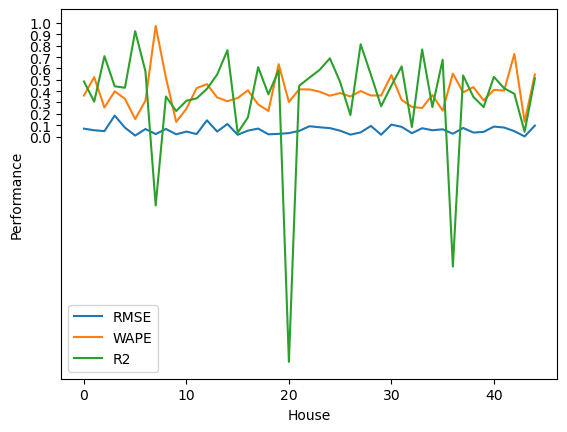

In [9]:
show_all_metrics_per_house(metrics_list_lr, number_of_houses)

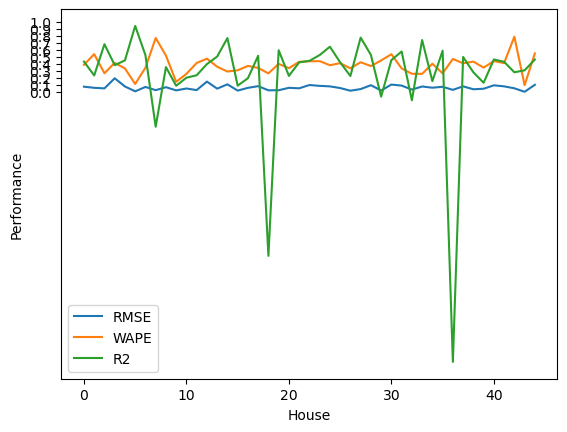

In [10]:
show_all_metrics_per_house(metrics_list_xgb, number_of_houses)

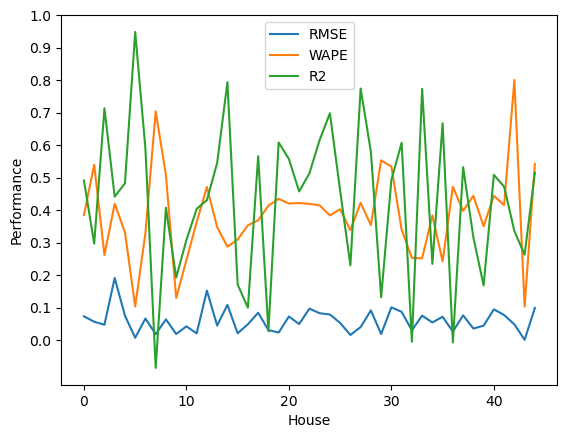

In [11]:
show_all_metrics_per_house(metrics_list_rf, number_of_houses)

### Total average

In [12]:
t_rmse_lr, t_wape_lr, t_r2_lr = total_averaged_metrics_individual(metrics_list_lr)

Total Averaged RMSE: 0.058
Total Averaged WAPE: 38.417
Total Averaged R2: 0.34


In [13]:
t_rmse, t_wape, t_r2 = total_averaged_metrics_individual(metrics_list_xgb)

Total Averaged RMSE: 0.061
Total Averaged WAPE: 38.574
Total Averaged R2: 0.229


In [14]:
t_rmse_rf, t_wape_rf, t_r2_rf = total_averaged_metrics_individual(metrics_list_rf)

Total Averaged RMSE: 0.06
Total Averaged WAPE: 38.695
Total Averaged R2: 0.429


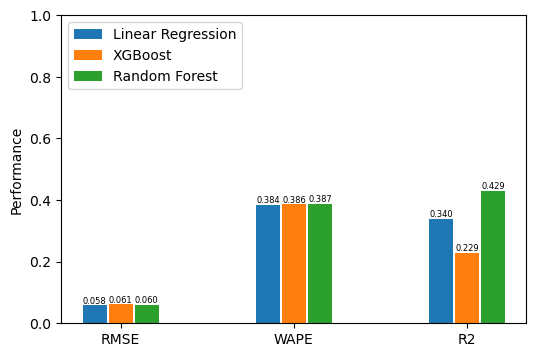

In [15]:
rmse = t_rmse_lr, t_rmse, t_rmse_rf
wape = t_wape_lr, t_wape, t_wape_rf
r2 = t_r2_lr, t_r2, t_r2_rf
model_names = ['Linear Regression', 'XGBoost', 'Random Forest']
X_names = ['RMSE', 'WAPE', 'R2']
X_axis = np.arange(len(X_names))
pos = 0
bar_width = 0.15
fig, ax = plt.subplots(figsize=(6, 4))

for i in range(len(model_names)):
    bar = (rmse[i], wape[i]/100, r2[i])
    b = ax.bar(X_axis + pos, bar, bar_width-0.01, label=model_names[i])
    pos = pos + bar_width
    ax.bar_label(b, fontsize=6, fmt='%.3f')
    
ax.set_ylim(0,1)
ax.set_xticks(X_axis+bar_width,X_names)
ax.set_ylabel("Performance")
#ax.set_xlabel("Metrics")
#ax.set_title(title)
ax.legend(loc='upper left')
#plt.savefig(filename)
plt.show()